<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/4_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Ayesha Khan

# Table of Contents:

  ## 1. Initial Setup
  ## 2. Helper Functions
  ## 3. Data Download
  ## 4. Data Preprocessing
  ## 5. Data Preparation for MLP + Granger Analysis
  ## 6. Model Setup
  ## 7. Training
  ## 8. Evaluation
  ## 9. Observations

# Initial setup, declarations and method definitions




In [13]:
import requests
import json
import pandas as pd
import os
import csv
from datetime import datetime

from sklearn.metrics import mean_squared_error


## Mount Google drive

In [14]:
"""
# Mount google drive when working in colab
hasCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if hasCOLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  BASEPATH = '/content/drive/MyDrive'
else:
  BASEPATH = '.'
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Global constants
TIMESERIES_DATA_DIR = BASEPATH + "/timeseries_data/"
# Storage of actual values
TIMESERIES_CSV_DIR = os.path.join(TIMESERIES_DATA_DIR, "toar_csv_timeseries")
# Storage of Timeseries IDs
TIMESERIES_ID_FILE = os.path.join(TIMESERIES_DATA_DIR, "timeseriesIDs.json")
# Min file size for sanity check
MIN_FILE_SIZE_BYTES = 100
# expected columns from download
group_columns = ['station_code', 'latitude', 'longitude']

# create directories if not existing
os.makedirs(TIMESERIES_DATA_DIR, exist_ok=True)
os.makedirs(TIMESERIES_CSV_DIR, exist_ok=True)

In [16]:
# MLP related imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

# set length of past and future time series
# to be used in the model
# context_window is the number of past time steps
# prediction_horizon is the number of future time steps
context_window = 336
prediction_horizon = 96

# Helper functions

1. load_existing_timeseries,
2. save_timeseries_ids,
3. fetch_timeseries_data,
4. pivot handle,
5. csv download,
6. evaluate model
7. results saver (from task 1)
8. fill_six_nans
9. log transform if skewed
10. standard scaler
11. create sequences

In [18]:
def load_existing_timeseries_ids():
    """
    Load existing timeseries IDs from a JSON file.

    Returns:
        dict: A dictionary containing stored timeseries metadata.
    """
    return json.load(open(TIMESERIES_ID_FILE, 'r')) if os.path.exists(TIMESERIES_ID_FILE) else {}

def save_timeseries_ids(timeseries_data):
    """
    Save timeseries metadata to a JSON file.

    Args:
        timeseries_data (dict): A dictionary containing timeseries metadata.
    """
    json.dump(timeseries_data, open(TIMESERIES_ID_FILE, 'w'), indent=4)

def fetch_timeseries_data(station_codes, existing_timeseries, variable_columns):
    """
    Fetch timeseries metadata for given station codes, filtering by specified variables.

    Args:
        station_codes (list): List of station codes to fetch data for.
        existing_timeseries (dict): Dictionary of previously fetched timeseries metadata.
        variable_columns (list): List of variable names to retain.

    Returns:
        dict: Updated dictionary containing filtered timeseries metadata.
    """
    base_url = "http://toar-data.fz-juelich.de/api/v2/search/?codes="
    unique_entries = existing_timeseries.copy()
    processed_station_codes = {details['station_code'] for details in existing_timeseries.values()}

    for code in station_codes:
        if code in processed_station_codes:
            print(f"\t\tStation {code} is already processed, skipping.")
            continue

        response = requests.get(base_url + code, timeout=1000)
        if response.status_code == 200:
            for entry in response.json():
                if (variable_name := entry.get('variable', {}).get('name')) in variable_columns:
                    timeseries_id = entry.get('id')
                    if timeseries_id not in unique_entries:
                        unique_entries[timeseries_id] = {
                            'data_start_date': entry.get('data_start_date'),
                            'data_end_date': entry.get('data_end_date'),
                            'variable_name': variable_name,
                            'station_code': code,
                            'latitude': entry.get('station', {}).get('coordinates', {}).get('lat'),
                            'longitude': entry.get('station', {}).get('coordinates', {}).get('lng'),
                        }
        else:
            print(f"\t\tFailed to fetch data for station {code}. Status code: {response.status_code}")
    return unique_entries

def pivot_handle(dfs, metadata_columns, variable_columns):
    """
    Pivot and structure the timeseries dataframe for sequential data analysis.

    Args:
        dfs (pd.DataFrame): Dataframe containing timeseries data.
        metadata_columns (list): List of metadata column names.
        variable_columns (list): List of variable names to include.

    Returns:
        pd.DataFrame: Processed dataframe with pivoted structure.
    """
    pivot_df = dfs.pivot_table(index='datetime', columns='variable_name', values='value', aggfunc='mean')
    pivot_df.reset_index(inplace=True)

    print(f"Station {dfs['station_code'].unique()} min time: {dfs['datetime'].min()}, max time: {dfs['datetime'].max()}, hours between: {(dfs['datetime'].max() - dfs['datetime'].min()) / pd.Timedelta(hours=1):.2f}")
    reference_index = pd.date_range(start=dfs['datetime'].min(), end=dfs['datetime'].max(), freq="h", tz="UTC")
    reference_df = pd.DataFrame({'datetime': reference_index})

    pivot_df_ = reference_df.merge(pivot_df, on='datetime', how='left')

    for col in metadata_columns:
        if dfs[col].notna().any():
            value = dfs[col].dropna().iloc[0]
            pivot_df_.insert(0, col, value)
        else:
            print(f"Station {dfs['station_code'].unique()}: metadata {col} has no value")

    return pivot_df_

def download_csv_data(timeseries_data, variable_columns):
    """
    Download and process CSV data for each timeseries ID.

    Args:
        timeseries_data (dict): Dictionary containing timeseries metadata.
        variable_columns (list): List of variable names to process.

    Returns:
        pd.DataFrame: Combined dataframe of all timeseries data.
    """
    dataframes = []
    metadata_columns = ['station_code', 'latitude', 'longitude']

    for ts_id, details in timeseries_data.items():
        csv_path = os.path.join(TIMESERIES_CSV_DIR, f"{ts_id}.csv")

        if os.path.exists(csv_path) and os.path.getsize(csv_path) > MIN_FILE_SIZE_BYTES:
            print(f"\tCSV already exists for timeseries ID {ts_id}, skipping download.")
        else:
            print(f"\tDownloading data for timeseries ID {ts_id}")
            url = f"http://toar-data.fz-juelich.de/api/v2/data/timeseries/{ts_id}?format=csv"
            try:
                response = requests.get(url, stream=True, timeout=1000)
                response.raise_for_status()
                with open(csv_path, 'wb') as file:
                    file.writelines(response.iter_content(chunk_size=8192))
                print(f"\t\tRaw data CSV of {ts_id} saved: {csv_path}")
            except requests.exceptions.RequestException as e:
                print(f"\t\tFailed to download data for timeseries ID {ts_id}. Error: {e}")
                continue

        try:
            df = pd.read_csv(csv_path, skiprows=lambda i: i < next(i for i, line in enumerate(open(csv_path)) if line.startswith('datetime')), low_memory=False)
            df['datetime'] = pd.to_datetime(df['datetime'], format='mixed')
            df[['variable_name', 'station_code', 'latitude', 'longitude']] = details['variable_name'], details['station_code'], details['latitude'], details['longitude']
            print(f"Dataframe for timeseries ID {ts_id} loaded successfully with shape {df.shape}")
            dataframes.append(pivot_handle(df, metadata_columns, variable_columns))
        except (pd.errors.EmptyDataError, pd.errors.ParserError) as e:
            print(f"\tError processing CSV for timeseries ID {ts_id}: {e}")
            continue

    return pd.concat(dataframes, ignore_index=True).sort_values(by=['station_code', 'datetime']) if dataframes else pd.DataFrame()

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [19]:
# function to save forecast results in a structured format

import json
import os

def save_forecast(
        station: str,
        model: str,
        context_vals,               # 1-D array-like, X test values
        future_true,                # 1-D array-like, true future values
        future_pred,                # 1-D array-like, predicted future values
        episode_id,                 # int index, to identify the timeperiod
        folder=f"{BASEPATH}/results"): # default folder for results
    """
    One call per model-run. Stores just enough metadata to let the
    plotting notebook know what it’s looking at.
    """
    import os, json, numpy as np
    # make sure the base path exists
    os.makedirs(folder, exist_ok=True)

    # structure the result
    # note: context_vals, future_true, and future_pred should be 1-D arrays
    result = {
        "station":        station,              # <- allows filtering
        "episode_id":     episode_id,           # <- allows filtering
        "model":          model,                # <- allows choosing of model
        "context":        np.asarray(context_vals).tolist(),    # converts to numpy array and then to list
        "future_true":    np.asarray(future_true).tolist(),
        "future_pred":    np.asarray(future_pred).tolist()
    }

    # create a filename based on model, station, and episode_id
    fname = f"{model}_{station}_{episode_id}.json"

    # save the result to a JSON file
    with open(os.path.join(folder, fname), "w") as f:
        json.dump(result, f, indent=2)

    # let user know station code and episode_id for plotting purpose
    print(f"Results saved as {fname}, episode_id is {episode_id} and station is {station}")


In [20]:

def fill_six_nans(group):
    """
    Fills up to six consecutive NaN values in a given pandas Series using linear interpolation
    if the NaNs are surrounded by valid values. If the NaNs are at the start, they are replaced
    with zeros, and if they are at the end, they are filled with the last known value.

    Args:
        group (pd.Series): The input Series with potential NaN values.

    Returns:
        pd.Series: A Series where up to six consecutive NaNs are interpolated, and longer NaN
        sequences are partially filled while preserving the original index.
    """
    values = group.to_numpy()
    i = 0
    while i < len(values):
        if np.isnan(values[i]):
            start = i
            while i < len(values) and np.isnan(values[i]):
                i += 1
            end = min(i, start + 6)  # Limit to filling only 6 NaNs

            if start > 0 and i < len(values):  # NaNs in the middle
                fill_values = np.linspace(values[start - 1], values[i], end - start + 2)[1:-1]
            elif start == 0:  # NaNs at the start
                fill_values = [0] * (end - start)
            elif i >= len(values):  # NaNs at the end
                fill_values = [values[start - 1]] * (end - start)
            values[start:end] = fill_values
        else:
            i += 1
    return pd.Series(values, index=group.index)

In [21]:
from scipy.stats import skew

def log_transform_if_skewed(df, columns, threshold=1.0):
    """
    Log-transform the specified columns of a DataFrame based on their skewdness.

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names that need to be checked for skewdness.

    Returns:
        pd.DataFrame: DataFrame with normalized columns.
    """
    df_transformed = df.copy()

    for col in columns:
        # s = df[col].dropna()
        s = df[col]
        current_skewness = skew(s)

        print(f"[{col}] Skewness: {current_skewness:.2f}")

        if abs(current_skewness) > threshold:
            # To avoid log(0) or log(negative values).
            if (s <= 0).any():
                shift = abs(s.min()) + 1e-6
                print(f"Applying log(x + {shift:.6f}) to {col}")
                df_transformed[col] = np.log(df[col] + shift)
            else:
                print(f"Applying log(x) to {col}")
                df_transformed[col] = np.log(df[col])
        else:
            print(f"No transformation applied to {col}.")

    return df_transformed

In [22]:
# Function to create continous time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, variable_column, n_past=336, n_future=96):
    df = data.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(['station_code', 'datetime']).reset_index(drop=True)

    # 1) Encode station_code as a small integer (categorical codes) to save memory
    df['sc_code'] = df['station_code'].astype('category')

    # 2) Boolean mask: True if exactly 1 hour after the previous row (per station)
    is1h = (
        df.groupby('station_code')['datetime']
          .diff()
          .eq(pd.Timedelta(hours=1))
    )

    # 3) Compute how many consecutive “True” over (n_past + n_future - 1) rows
    gap_window = n_past + n_future - 1
    run = (
        is1h.groupby(df['station_code'])
            .rolling(window=gap_window, min_periods=gap_window)
            .sum()
            .reset_index(level=0, drop=True)
    )

    # 4) 'ends' are indices where run == gap_window (end of a full-length continuous block)
    ends = run[run == gap_window].index

    # 5) Grab column‐arrays for encoded station code and the variable
    sc_arr  = df['sc_code'].values
    vals    = df[variable_column].values

    X_list = []
    y_list = []
    for end_idx in ends:
        start_idx = end_idx - gap_window
        if start_idx >= 0 and sc_arr[start_idx] == sc_arr[end_idx]:
            station_block = sc_arr[start_idx : end_idx + 1]
            var_block     = vals[start_idx : end_idx + 1]

            block = np.column_stack((station_block, var_block))

            X_list.append(block[:n_past, :])
            y_list.append(block[n_past:, :])

    if not X_list:
        # No valid windows
        return np.empty((0, n_past, 2)), np.empty((0, n_future, 2))

    X = np.stack(X_list)  # shape = (num_windows, n_past, 2)
    y = np.stack(y_list)  # shape = (num_windows, n_future, 2)
    return X, y

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

# Data Download

In [8]:
# select station for download
station_codes = ["DENW094"]
# select variables for download
variable_columns = ["temp", "o3"]

## Download via REST API

In [ ]:
# Load existing timeseries IDs from json to skip calls to TOAR
existing_timeseries = load_existing_timeseries_ids()

# download timeseries IDs required
timeseries_data = fetch_timeseries_data(station_codes, existing_timeseries,variable_columns)
print(f"\t Number of time series meta data fetched : {len(timeseries_data)}")

# save existing timeseries IDs as json to reduce calls to TOAR in future
save_timeseries_ids(timeseries_data)

# download actual data and make into dataframe
dataframes = download_csv_data(timeseries_data,variable_columns)
print(f"\t Total dataFrames processed : {len(dataframes)} and shape of first dataframe {dataframes.shape}.")

dataframes.head()

		Station DENW094 is already processed, skipping.
	 Number of time series meta data fetched : 3
	CSV already exists for timeseries ID 76, skipping download.
Dataframe for timeseries ID 76 loaded successfully with shape (246648, 9)
Station ['DENW094'] min time: 1997-01-01 00:00:00+00:00, max time: 2025-07-01 07:00:00+00:00, hours between: 249799.00
	CSV already exists for timeseries ID 18022, skipping download.
Dataframe for timeseries ID 18022 loaded successfully with shape (220973, 9)
Station ['DEHE020'] min time: 1997-01-01 00:00:00+00:00, max time: 2025-07-01 07:00:00+00:00, hours between: 249799.00
	CSV already exists for timeseries ID 22639, skipping download.


In [ ]:
# save data in case session timeout
dataframes.to_csv(os.path.join(TIMESERIES_DATA_DIR, "raw_data.csv"), index=False)

Code in case of timeout to load data again:

In [ ]:
"""
# save data path variable
data_path = os.path.join(TIMESERIES_DATA_DIR, "raw_data.csv")
# read in raw data
dataframes = pd.read_csv(data_path,parse_dates=["datetime"])
"""

# Data Preprocessing

## Dealing with missing values

In [ ]:
# groups values by variable and fills in six NaN values
dataframes[variable_columns] = dataframes.groupby(group_columns)[variable_columns].transform(fill_six_nans)
# checks number of na values
dataframes.isna().sum()
# drop remaining na values
dataframes = dataframes.dropna()
# check again
dataframes.isna().sum()

## Statistical Sanity Check

In [ ]:
stats = ['min', 'max', 'mean', 'sum', 'std', 'var', 'median','prod','nunique',
    ('5th_percentile', lambda x: x.quantile(0.05)),
    ('10th_percentile', lambda x: x.quantile(0.10)),
    ('25th_percentile', lambda x: x.quantile(0.25)),
    ('50th_percentile', lambda x: x.quantile(0.50)), #(median)
    ('75th_percentile', lambda x: x.quantile(0.75))]
agg_dict = {col: stats for col in variable_columns}
grouped = dataframes.groupby('station_code').agg(agg_dict)
display(grouped)

for agg_func in ['min', 'max', 'mean', 'std']:
    display(agg_func)
    agg_view = grouped.xs(agg_func, axis=1, level=1)
    display(agg_view)

no2                                               \
                   min        max      mean           sum       std   
station_code                                                          
DENW094      -2.544249  81.321835  7.576288  5.309811e+06  6.360161   

                                                               ...     press  \
                    var    median prod nunique 5th_percentile  ...       std   
station_code                                                   ...             
DENW094       40.451654  5.648076 -0.0  289712        1.25063  ...  9.810325   

                                                                               \
                    var    median prod nunique 5th_percentile 10th_percentile   
station_code                                                                    
DENW094       96.242473  993.1915  0.0  170209        975.432           980.0   

                                                              
             25th_percentile 50th_percentile 75th_percentile  
station_code                                                  
DENW094           987.046385        993.1915        998.9072  

[1 rows x 70 columns]

'min'

,no2,temp,o3,no,press
station_code,,,,,
DENW094,-2.544249,-17.35,-1.417507,-3.360428,0.0


'max'

,no2,temp,o3,no,press
station_code,,,,,
DENW094,81.321835,39.0784,134.83356,447.81647,1023.717


'mean'

,no2,temp,o3,no,press
station_code,,,,,
DENW094,7.576288,10.68534,24.713563,3.301673,992.484116


'std'

,no2,temp,o3,no,press
station_code,,,,,
DENW094,6.360161,7.440747,14.653677,8.852862,9.810325


# Data Preparation for MLP + Granger Analysis

## Improving ditribution

### Log Scaling after checking for skewdness

In [ ]:
# log transofmr data if distribution is not gaussian
dataframe_= log_transform_if_skewed(dataframes, variable_columns, threshold=1.0)
dataframe_.head()

### Normalise the data

In [ ]:
# z-normalisation of data
dataframes = standard_scaler(dataframe_, variable_columns)
# show dataframe
dataframes.head()

##### Save the normalized dataframe for later use

In [ ]:
dataframes.to_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"), index=False)

## Granger Analysis

😈 **Task 3:** Run a Granger test between `temp` and `o3`. Is there any directional causality?

😈 **Question 3:** Why is Granger causality not the same as actual causality?
Granger causality only checks if it is possible to predict the relationship between two series; it does not establish the actual causality. So it could be only correlation.


In [12]:
# get data from normalised data stored in gdrive
dataframes = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"), parse_dates=["datetime"])
from statsmodels.tsa.stattools import grangercausalitytests
print(f"\nTesting directional causality between temp and o3:")
grangercausalitytests(dataframes[['o3', 'temp']], maxlag=4)
grangercausalitytests(dataframes[['temp', 'o3']], maxlag=4)


Testing directional causality between temp and o3:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=126.7824, p=0.0000  , df_denom=700842, df_num=1
ssr based chi2 test:   chi2=126.7830, p=0.0000  , df=1
likelihood ratio test: chi2=126.7715, p=0.0000  , df=1
parameter F test:         F=126.7824, p=0.0000  , df_denom=700842, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1479.4247, p=0.0000  , df_denom=700839, df_num=2
ssr based chi2 test:   chi2=2958.8705, p=0.0000  , df=2
likelihood ratio test: chi2=2952.6420, p=0.0000  , df=2
parameter F test:         F=1479.4247, p=0.0000  , df_denom=700839, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2517.0234, p=0.0000  , df_denom=700836, df_num=3
ssr based chi2 test:   chi2=7551.1455, p=0.0000  , df=3
likelihood ratio test: chi2=7510.7560, p=0.0000  , df=3
parameter F test:         F=2517.0234, p=0.0000  , df_denom=700836, df_num=3

Granger Causali

{np.int64(1): ({'ssr_ftest': (np.float64(1123.446028097791),
    np.float64(4.156613845185853e-246),
    np.float64(700842.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1123.450837081962),
    np.float64(2.6425772564189183e-246),
    np.int64(1)),
   'lrtest': (np.float64(1122.5513553153723),
    np.float64(4.144969079843009e-246),
    np.int64(1)),
   'params_ftest': (np.float64(1123.446028097952),
    np.float64(4.156613844698179e-246),
    np.float64(700842.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(3125.7956319505156),
    np.float64(0.0),
    np.float64(700839.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(6251.635864667141),
    np.float64(0.0),
    np.int64(2)),
   'lrtest': (np.float64(6223.917800734751), np.float64(0.0), np.int64(2)),
   'params_ftest': (np.float64(3125.7956319494133),
    np.float64(0.0),
    np.float64(700839.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 np.int64(3): 

p values less than 0.001 in both directions - they both "Granger-cause" each other

## Dataloading

In [23]:
# get data from normalised data stored in gdrive
dataframes = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"), parse_dates=["datetime"])
# remove variables other than temp and O3
dataframes = dataframes[["station_code", "datetime", "temp", "o3"]]
# reducing data size to be able to use in Colab
dataframes = dataframes[(dataframes['datetime']>='1997-01-01') & (dataframes['datetime']<='2008-01-01')]

70/30 train/test split chosen

In [24]:
# set number of timesteps used as "past" values
context_window = 336
# set number of timesteps used as "future" values + also number of values predicted by model later
prediction_horizon = 96
# variable columns
variable_column = ["temp", "o3"]

# create sequences of continuous values
X, y = create_sequences(dataframes,variable_column,context_window,prediction_horizon)

train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (0, 336, 2), y_train shape: (0, 96, 2)
X_test shape: (0, 336, 2), y_test shape: (0, 96, 2)


In [26]:
# checking for hourly gaps
df = dataframes.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(['station_code','datetime'])
diffs = df.groupby('station_code')['datetime'].diff()
print(diffs.value_counts().head())


datetime
0 days 00:00:00    182093
0 days 01:00:00     48684
0 days 02:00:00       133
0 days 04:00:00        42
0 days 03:00:00        36
Name: count, dtype: int64


In [29]:
# dropping duplicates
dataframes = (
    dataframes
    .sort_values('datetime')
    .drop_duplicates(subset=['datetime'], keep='first')
)

In [30]:
# set number of timesteps used as "past" values
context_window = 336
# set number of timesteps used as "future" values + also number of values predicted by model later
prediction_horizon = 96
# variable columns
variable_column = ["temp", "o3"]

# create sequences of continuous values
X, y = create_sequences(dataframes,variable_column,context_window,prediction_horizon)

train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (4167, 336, 3), y_train shape: (4167, 96, 3)
X_test shape: (1787, 336, 3), y_test shape: (1787, 96, 3)


In [32]:
import numpy as np

# Drop station_code channel → keep only temp & o3 as inputs
X_train_vars = X_train[:, :, 1:1+len(variable_column)].astype(np.float32)
X_test_vars  = X_test [:, :, 1:1+len(variable_column)].astype(np.float32)

# Pick out only the ozone target from y (o3 is index 1 in variable_column)
o3_idx      = variable_column.index("o3")          # find where “o3” is
y_train_o3  = y_train[:, :, 1 + o3_idx].astype(np.float32)  # (4167, 96)
y_test_o3   = y_test [:, :, 1 + o3_idx].astype(np.float32)  # (1787, 96)

# Now X_train_vars has shape (n,336,2) and y_train_o3 is (n,96)
print(f"X_train_vars shape: {X_train_vars.shape}, y_train_o3 shape: {y_train_o3.shape}")
print(f"X_test_vars  shape: {X_test_vars.shape},  y_test_o3  shape: {y_test_o3.shape}")


X_train_vars shape: (4167, 336, 2), y_train_o3 shape: (4167, 96)
X_test_vars  shape: (1787, 336, 2),  y_test_o3  shape: (1787, 96)


Not sure if I did the right thing by dropping duplicates just like that.

# Model Setup

## Hyperparameters

In [33]:
# set hyperparameters for the model

mlp_hidden_units = [64, 32] # hidden layer sizes
mlp_epochs = 5 # number of epochs to train the model
mlp_batch_size = 16 # batch size for training
activation_fn='relu' # activation function for the hidden layers
mlp_optim = 'adam' # optimizer for the model
mlp_loss = 'mse' # loss function for the model

# Training

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError

# Checkpoint directory for saving models
checkpoint_dir = "./checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

num_variables = 1  # We only train one model for ozone forecast

mlp_predictions = []
training_histories = {}

for var_idx in range(num_variables):
    print(f"\nTraining model for variable {var_idx + 1}/{num_variables}")

    # Flatten multivariate past window: (samples, 336, 2) → (samples, 672)
    X_train_single = X_train_vars.reshape(X_train_vars.shape[0], -1)
    X_test_single  = X_test_vars.reshape(X_test_vars.shape[0], -1)

    # Ozone targets: shape (samples, 96)
    y_train_single = y_train_o3.reshape(y_train_o3.shape[0], -1)

    # Define model checkpoint file for saving
    checkpoint_path = os.path.join(checkpoint_dir, f"mlp_var{var_idx}.h5")

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {var_idx + 1}")
        mlp_model = load_model(checkpoint_path, custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {var_idx + 1}")

        # Build MLP model: input is flattened past (672,), output is 96 future steps
        mlp_model = Sequential([
            Input(shape=(X_train_single.shape[1],)),
            Dense(mlp_hidden_units[0], activation=activation_fn)
        ])

        # Add additional hidden layers
        for units in mlp_hidden_units[1:]:
            mlp_model.add(Dense(units, activation=activation_fn))

        # Final output layer predicts 96 ozone values
        mlp_model.add(Dense(y_train_single.shape[1]))
        mlp_model.compile(optimizer=mlp_optim, loss=mlp_loss)

        # Save the best model during training
        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        # Train the model
        training = mlp_model.fit(
            X_train_single, y_train_single,
            epochs=mlp_epochs, batch_size=mlp_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )
        training_histories[var_idx] = training.history

    # Predict future ozone values
    y_pred_single = mlp_model.predict(X_test_single.astype(np.float32))
    mlp_predictions.append(y_pred_single)

# Reshape predictions to (samples, 96, num_variables)
mlp_predictions = np.concatenate(mlp_predictions, axis=-1).reshape(y_test_o3.shape[0], prediction_horizon, num_variables)
y_pred_single = y_pred_single.reshape(y_pred_single.shape[0], prediction_horizon, 1)


# Evaluation

In [ ]:
# Reshape ground truth y_test to match the prediction structure: (samples, pred_horizon, num_variables)
y_test_reshaped = y_test_o3.reshape(y_test_o3.shape[0], prediction_horizon, num_variables)

# Slice out the ozone results (only one page since num_variables=1)
y_test_selected = y_test_reshaped[:, :, var_idx]
y_pred_selected = mlp_predictions[:, :, var_idx]

# Compare predicted vs. true ozone curves for all test samples
evaluate_model(y_test_selected, y_pred_selected)

RMSE: 0.4805


np.float64(0.48048014743591644)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


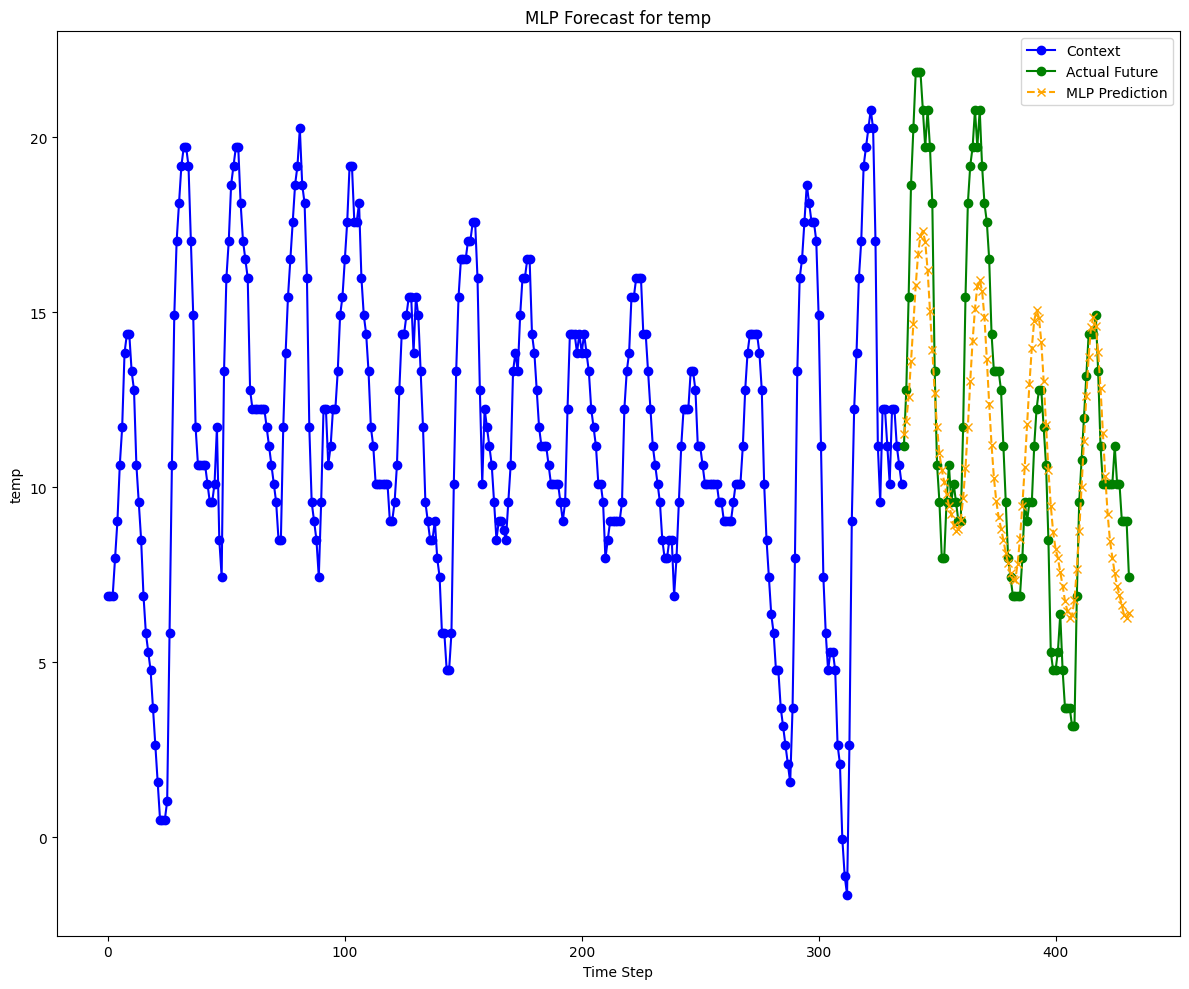

In [ ]:
# Recalculate scaler_stats if missing
scaler_stats = {
    "temp": {'mean': dataframes["temp"].mean(), 'std': dataframes["temp"].std()},
    "o3": {'mean': dataframes["o3"].mean(), 'std': dataframes["o3"].std()}
}

plt.figure(figsize=(12, 6))

# Load ozone model
mlp_model = load_model(
    os.path.join(checkpoint_dir, "mlp_var0.h5"),
    custom_objects={"mse": MeanSquaredError()}
)

# Just take first test sample (no station filtering needed if single-station)
first_idx = 0

# Extract context inputs (temp, o3) and future ozone
context_temp = X_test_vars[first_idx, :, 0] * scaler_stats["temp"]['std'] + scaler_stats["temp"]['mean']
context_o3   = X_test_vars[first_idx, :, 1] * scaler_stats["o3"]['std'] + scaler_stats["o3"]['mean']

actual_future = y_test_o3[first_idx, :] * scaler_stats["o3"]['std'] + scaler_stats["o3"]['mean']

# Flatten inputs for model
X_flat = X_test_vars[first_idx].reshape(1, -1).astype(np.float32)

# Predict future ozone
pred_future = mlp_model.predict(X_flat).flatten()
predicted_future = pred_future * scaler_stats["o3"]['std'] + scaler_stats["o3"]['mean']

# Plot
plt.plot(range(context_window), context_temp, label="Context Temp", color="lightblue")
plt.plot(range(context_window), context_o3, label="Context O3", color="blue")
plt.plot(range(context_window, context_window + prediction_horizon), actual_future, label="Actual Future O3", color="green", marker="o")
plt.plot(range(context_window, context_window + prediction_horizon), predicted_future, label="MLP Prediction O3", linestyle="--", color="orange", marker="x")

plt.title("MLP Forecast for Ozone (First Test Sample)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# Save forecast
save_forecast(
    station="DENW094",
    model="MLP",
    episode_id=1,
    context_vals=context_o3,
    future_true=actual_future,
    future_pred=predicted_future,
    folder=f"{BASEPATH}/hw_results"
)


# Observations

# Observations for Task 2

# I was able to generate valid sequences for multivariate forecasting after fixing the dataset.
# The issue was duplicate timestamps, which initially caused zero valid windows.
# After dropping duplicates per hour, the create_sequences function worked, though I'm not sure this is the best solution.
# I didn't complete model training due to time limits and compute problems.
# I plan to work on the training and evaluation steps later to properly compare results.
